# INTRODUCTION TO DATA VISUALIZATION WITH PYTHON SEABORN
#### IGGI Conference 2018 Workshop with Valerio Bonometti & Myat Aung

This is a workshop created for the IGGI Symposium of 2018. As the workshop is quite brief, we will try and cover a broad range of seaborn and dataviz with 15 minutes per excercise. 

A note on the programming quality of this workshop: our focus here was to present seaborn in the quickest-to-learn manner for a time constrained workshop. As such, some styling here may be particularly offensive (as well as some hardcoding). For this, we do apologise in advance, but hopefully you can find something useful from this.

A final warning before we continue, some of the later cells in this notebook can be a bit computationally intensive for older or laptop hardware, so we advise against running all cells unless you accept some non-insignificant load. 

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neural_network import MLPClassifier as MLPC

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from toolbox.tools import *

import statsmodels.api as sm

In [17]:
df_gm = pd.read_csv('data\\dataframe.csv')
df_ml = pd.read_csv('data\\dataframe_ml.csv')
df_ts = generate_time_series(len_series=100, n_conditions=2, n_individuals=100)
df_ln = generate_linear(n_individuals=30, n_conditions=2)
df_pl = generate_poly(n_individuals=30, n_conditions=2, order = 3)

## INTRODUCTION

For the start of this workshop, we will work briefly with a basic dataset of NBA player statistics from the season of 2017-2018 provided by [Basketball Reference](https://www.basketball-reference.com/leagues/NBA_2018_per_game.html). 

In [18]:
nba_df = pd.read_csv('data\\nba.csv')

### Exploratory Analysis & Visualisation - Example Dataset with NBA Players

<img src="presentations/figures/pandas_numpy.jpg" alt="drawing" width="300"/>

It's always a good idea to start by taking a cursory glance at your dataframe, to see what's there and to make sure the data is structured in a manner that you desire. You can peek at (and pull data from) the head and tail of your dataframe using head() and tail() methods. 

In [19]:
nba_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,1,Alex Abrines\abrinal01,SG,24,OKC,75,8,15.1,1.5,3.9,...,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7
1,2,Quincy Acy\acyqu01,PF,27,BRK,70,8,19.4,1.9,5.2,...,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9
2,3,Steven Adams\adamsst01,C,24,OKC,76,76,32.7,5.9,9.4,...,0.559,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9
3,4,Bam Adebayo\adebaba01,C,20,MIA,69,19,19.8,2.5,4.9,...,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9
4,5,Arron Afflalo\afflaar01,SG,32,ORL,53,3,12.9,1.2,3.1,...,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4


For a quick table of summary statistics, dataframes have a describe() method that quickly pulls some descriptive statistics of our data distributions.

In [20]:
nba_df.describe()

,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,660.000000,664.00000,664.000000,...,606.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.00000,664.000000,664.000000,664.000000
mean,270.823795,26.194277,43.280120,19.707831,18.637500,2.942018,6.539608,0.441359,0.77756,2.217922,...,0.741058,0.750301,2.511747,3.260090,1.744729,0.600000,0.35000,1.054066,1.583735,7.895030
std,154.830333,4.127665,27.743598,26.615675,9.306127,2.098904,4.471864,0.122191,0.77679,2.001853,...,0.147869,0.706467,1.778643,2.346761,1.672275,0.441784,0.36729,0.800480,0.773334,5.799271
min,1.000000,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,139.000000,23.000000,17.000000,0.000000,11.300000,1.400000,3.100000,0.395000,0.10000,0.500000,...,0.667000,0.300000,1.200000,1.700000,0.600000,0.300000,0.10000,0.500000,1.000000,3.575000
50%,266.500000,26.000000,46.000000,4.000000,18.600000,2.500000,5.500000,0.440000,0.60000,1.700000,...,0.768000,0.500000,2.200000,2.800000,1.200000,0.500000,0.30000,0.900000,1.600000,6.550000
75%,401.250000,29.000000,71.000000,35.000000,26.100000,4.200000,9.300000,0.493000,1.30000,3.500000,...,0.833000,1.000000,3.300000,4.400000,2.300000,0.800000,0.50000,1.400000,2.100000,11.400000
max,540.000000,41.000000,82.000000,82.000000,36.900000,10.500000,21.100000,1.000000,4.20000,10.000000,...,1.000000,5.100000,10.900000,16.000000,10.300000,2.400000,2.60000,5.000000,4.000000,30.400000


We will now begin with some descriptive visualisations to explore this data. Some examples here are not the best of exploratory analyses, but the focus here is the visualistion. 

For this, we use seaborn, which is used in conjunction with Matplotlib in order to generate some very quick and very attractive graphs. Let's start with simple boxplots. However, if we just use the boxplot() method on all our variables, the figure will be incomprehensible. So, we will use .loc to access the columns of interest. 

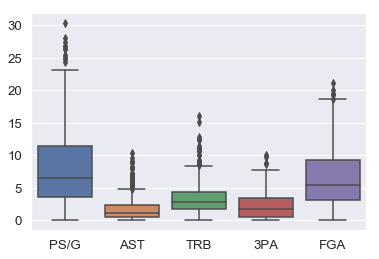

In [21]:
boxplot_df = nba_df.loc[: ,['PS/G', 'AST', 'TRB', '3PA', 'FGA']]
sns.boxplot(data=boxplot_df)
plt.show()

Notice that PS/G (Points per Game) is causing somewhat of an imbalance in this figure, so we can opt to recreate the same plot with a filter. Let's compare the 2 closest variables, Total Rebounds and 3 Point Attempts.

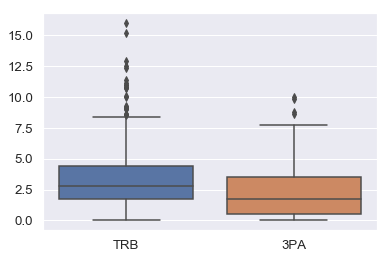

In [22]:
boxplot_df = boxplot_df.drop(['PS/G', 'AST', 'FGA'], axis=1)
sns.boxplot(data=boxplot_df)
plt.show()

The boxplot is a very nice visualisation of the median, quartiles, and potential outliers of your data. However, in many cases the violin plot is a more desirable visualisation, especially in cases where your distribution might be bimodal or multimodal. Check [Miao Yu's github page on violin plots](https://yufree.github.io/blog/2013/08/15/boxplot-vs-violinplot.html) for some quick literature on this. 

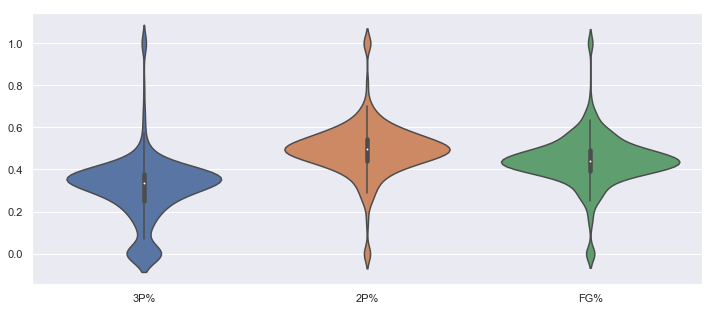

In [23]:
sns.set(font_scale=1, style = 'darkgrid', context='notebook', rc={"figure.figsize": (12, 5)})
#Generate smaller dataframe for violin plot
violinplot_df = nba_df.loc[: ,['3P%', '2P%', 'FG%']]

sns.violinplot(data=violinplot_df)
plt.show()

Now let's try to take a closer look at our data. In the NBA, players play one of five positions (at least in name) and we could draw a simple count plot (also known as a bar graph) of this. 

Before we continue, notice in our dataframe originally that 'Pos' is currently a string, so we will need to work with a new column that will allow us to enumerate these. 

In [24]:
nba_df['Position'] = nba_df['Pos']
nba_df['Pos'] = nba_df.Pos.astype('category').cat.codes.astype(np.int64)
nba_df.fillna(0)
nba_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Position
0,1,Alex Abrines\abrinal01,6,24,OKC,75,8,15.1,1.5,3.9,...,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,SG
1,2,Quincy Acy\acyqu01,1,27,BRK,70,8,19.4,1.9,5.2,...,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9,PF
2,3,Steven Adams\adamsst01,0,24,OKC,76,76,32.7,5.9,9.4,...,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9,C
3,4,Bam Adebayo\adebaba01,0,20,MIA,69,19,19.8,2.5,4.9,...,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9,C
4,5,Arron Afflalo\afflaar01,6,32,ORL,53,3,12.9,1.2,3.1,...,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4,SG


Now let's look at the frequencies of players in each position and draw the plot.

In [25]:
nba_df['Position'].value_counts()

SG       156
PG       142
C        126
PF       122
SF       115
SF-SG      2
PG-SG      1
Name: Position, dtype: int64

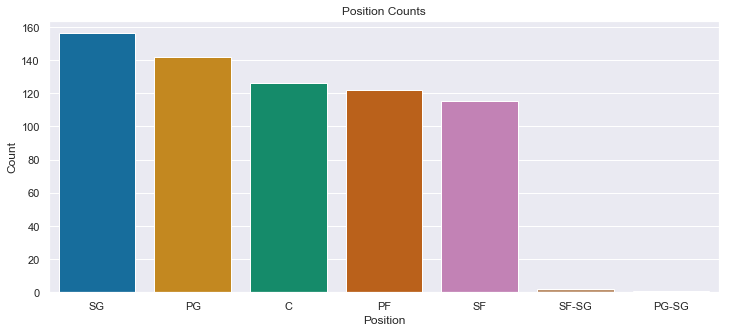

In [26]:
sns.set(font_scale=1, style = 'darkgrid', context='notebook', rc={"figure.figsize": (12, 5)})
# Create an order variable to sort by descending
pos_desc = nba_df['Position'].value_counts().sort_values(ascending=False).index

pos_countplot = sns.countplot(x='Position', 
                              data=nba_df, 
                              order=pos_desc, 
                              palette="colorblind")
plt.title('Position Counts')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

It seems there are some players who are labelled differently in the data. We will deal with this later on when we return to the positions data. 

For now, let's take a look at distribution plots of some offense data. We'll examine Points per Game (PS/G) and 3 Point Shots per Game (3P). 

In seaborn, histograms and continuous probability distributions (Kernel Density Estimations) are combined into a single plot type. You can amend the parameters of distplot() to remove one or the other. 

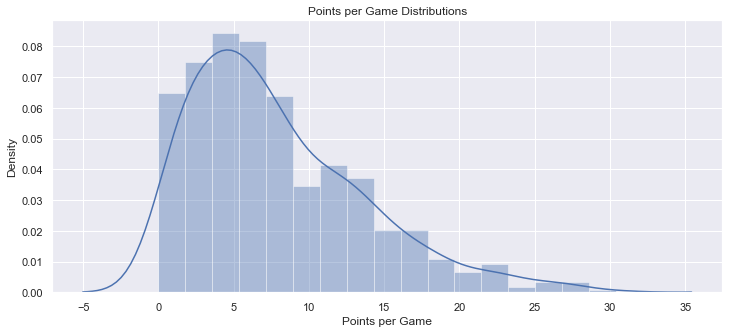

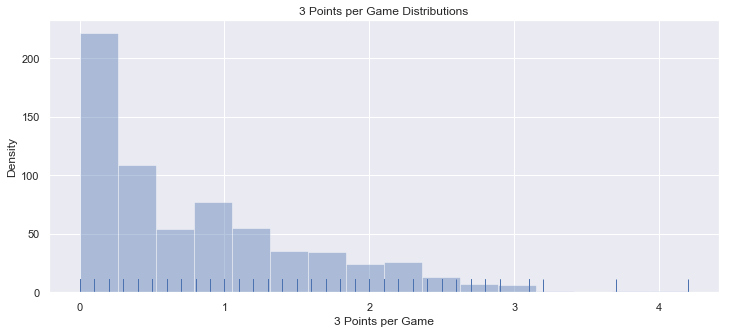

In [27]:
### sns.set(font_scale=1, style = 'darkgrid', context='notebook')

psg_distplot = sns.distplot(nba_df['PS/G'], 
                            label='Points per Game')
plt.title('Points per Game Distributions')
plt.xlabel('Points per Game')
plt.ylabel('Density')
plt.show()

p3_distplot = sns.distplot(nba_df['3P'], 
                           label='3 Points per Game',
                           kde=False,
                           rug=True)
plt.title('3 Points per Game Distributions')
plt.xlabel('3 Points per Game')
plt.ylabel('Density')
plt.show()

We can also carry out some caveman correlations here, by generating a correlation matrix of (nearly) all of our variables. I removed some variables here to make the figure slightly easier to read. 

The heatmap() method is flexible for many matrices, so we recommend you to play around and think about how you might use this elsewhere. Later on, we'll revisit this figure in the machine learning analysis of the workshop.

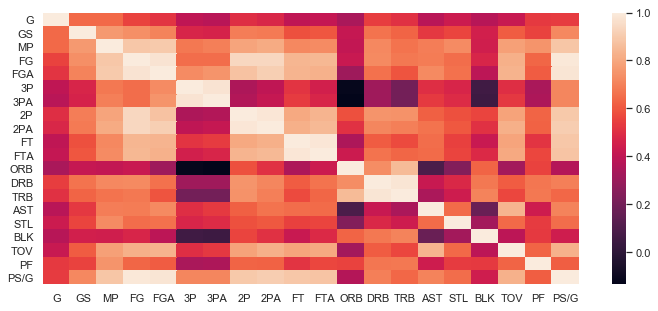

In [28]:
corrmat_df = nba_df.drop(['Rk', 'Player', 'Pos', 'Tm', 'Age',
                         '2P%', '3P%', 'FG%', 'FT%', 'eFG%'], 
                         axis=1)

corrmat = corrmat_df.corr()
sns.heatmap(corrmat)
plt.show()

Let's turn to the scatterplot for a moment. Here, we'll plot the assists players are making against their turnovers. It's conceivable that if you're making a lot of passes, you'll also miss occassionally and end up turning the ball over to the other team. 

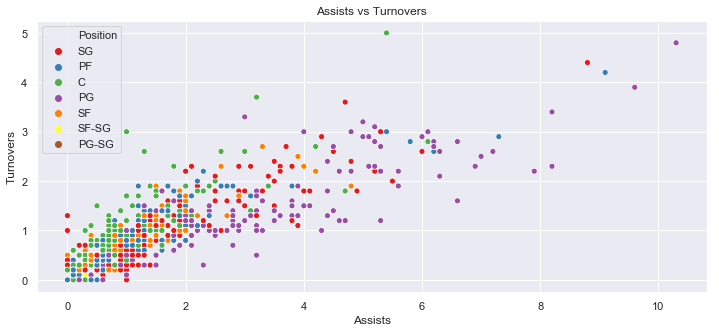

In [29]:
scoring_scatterplot = sns.scatterplot(x='AST', 
                                      y='TOV', 
                                      hue='Position', 
                                      palette='Set1', 
                                      data=nba_df)
plt.title('Assists vs Turnovers')
plt.xlabel('Assists')
plt.ylabel('Turnovers')
plt.show()

Because this is professional sports, we can find outliers in many directions. In the second plot, we increase the size of the graph in order to visualise this difference even further. If you are presenting data to people and you wish to (honestly!) emphasise your data in such a way, this is a valuable manipulation in your toolbox.

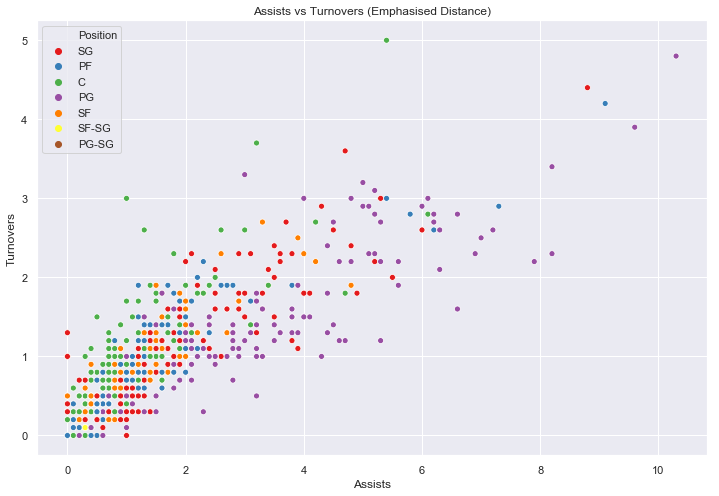

In [30]:
sns.set(font_scale=1, style = 'darkgrid', context='notebook', rc={"figure.figsize": (12, 8)})
scoring_scatterplot = sns.scatterplot(x='AST', 
                                      y='TOV', 
                                      hue='Position', 
                                      palette='Set1', 
                                      data=nba_df)
plt.title('Assists vs Turnovers (Emphasised Distance)')
plt.xlabel('Assists')
plt.ylabel('Turnovers')
plt.show()

Although I am not a big fan of incredibly dense visualisations and even though it's not the most applicable here, we demonstrate that a pairplot is effective at showing a multiplot figure across multiple variables.

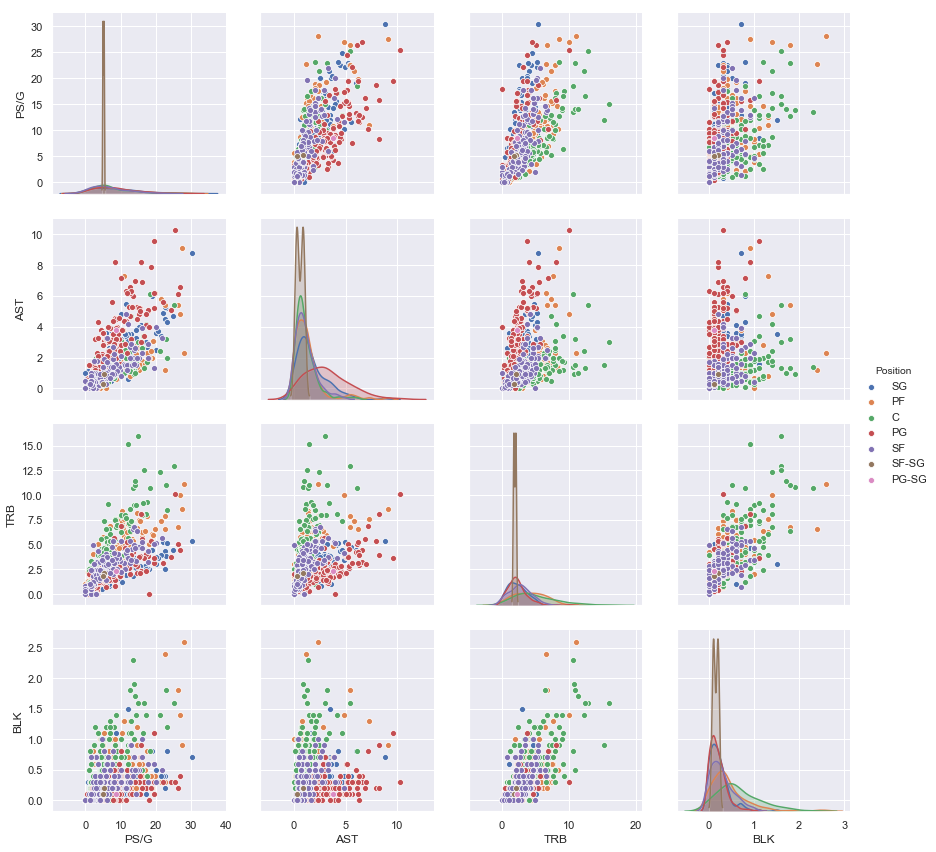

In [31]:
pairplot_df = nba_df.loc[: ,['PS/G', 'AST', 'TRB', 'BLK', 'Position']]

nba_pairplot = sns.pairplot(pairplot_df, 
                            hue='Position', 
                            height=3)
plt.show()

Remember that our positions data needs some cleaning up. We'll use a .ix to access indices with certain boolean conditions, in this case we search for the offending position entries. From here, we observe that there are 2 players in the SF-SG role and 1 in PG-SG. 

In [32]:
SF_SG = nba_df.ix[nba_df['Position']=='SF-SG'] 
PG_SG = nba_df.ix[nba_df['Position']=='PG-SG'] 
print(SF_SG)
print(PG_SG)

      Rk                      Player  Pos  Age   Tm   G  GS    MP   FG  FGA  \
75    63      Corey Brewer\breweco01    5   31  TOT  72  18  16.8  2.0  4.4   
440  358  Shabazz Muhammad\muhamsh01    5   25  TOT  43   2   9.7  2.0  4.4   

       ...     ORB  DRB  TRB  AST  STL  BLK  TOV   PF  PS/G  Position  
75     ...     0.6  1.5  2.1  0.9  1.1  0.2  0.7  1.9   5.3     SF-SG  
440    ...     0.5  1.2  1.8  0.3  0.2  0.1  0.1  0.7   5.0     SF-SG  

[2 rows x 31 columns]
     Rk                   Player  Pos  Age   Tm   G  GS    MP   FG  FGA  \
100  84  Isaiah Canaan\canaais01    3   26  TOT  20   1  21.1  2.6  6.9   

       ...     ORB  DRB  TRB  AST  STL  BLK  TOV   PF  PS/G  Position  
100    ...     0.3  2.0  2.3  3.8  0.8  0.1  1.5  1.8   8.6     PG-SG  

[1 rows x 31 columns]


To fix this, we will simply re-assign players in these positions to the prefix of their combined role names. To accomplish this, Pandas dataframes can use .at to manipulate specific indices of data. The plot is easier to read after this fix.

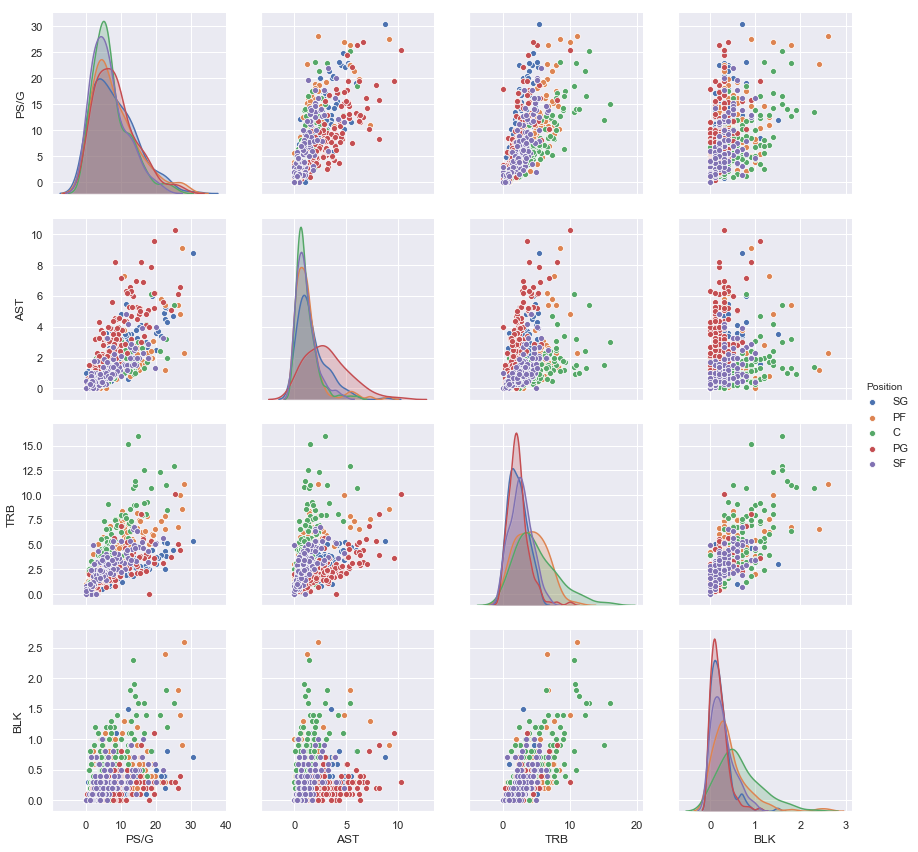

In [33]:
nba_df.at[75, 'Position'] = 'SF'
nba_df.at[440, 'Position'] = 'SF'
nba_df.at[100, 'Position'] = 'PG'
pairplot_df = nba_df.loc[: ,['PS/G', 'AST', 'TRB', 'BLK', 'Position']]

nba_pairplot = sns.pairplot(pairplot_df, 
                            hue='Position', 
                            height=3)
plt.show()

Let's try running a quick and dirty analysis. jointplots are particularly nice at showing layered information of our data distribution and comes with several 'kinds'. In this case, we use 'reg' for regression. 

Let's look at whether inefficient 3 Point shooting negatively impacts overall field accuracy. Some players are known to 'chuck' long ranged shots at first opportunity and are less statistically efficient because of this. We'll take a look at whether this inefficiency also translates to their overall accuracy. 

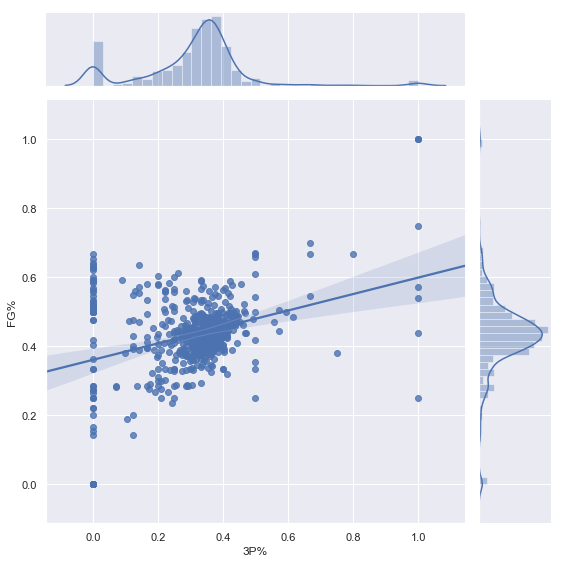

In [34]:
sns.set(font_scale=1, style = 'darkgrid', context='notebook')
scoring_jointplot = sns.jointplot(x='3P%', 
                                  y='FG%', 
                                  height=8, 
                                  kind='reg', 
                                  data=nba_df)
plt.show()

Based on what we can see here, this figure can be improved. For example, some players (especially bigger players) do not shoot long ranged shots at all. In addition to this, six players have an incredible long range accuracy of 100%!. Let's check if this outlier is valid.  

We can constrain our question a little more and instead look specifically at players who take more than one attempt per game, on average. 

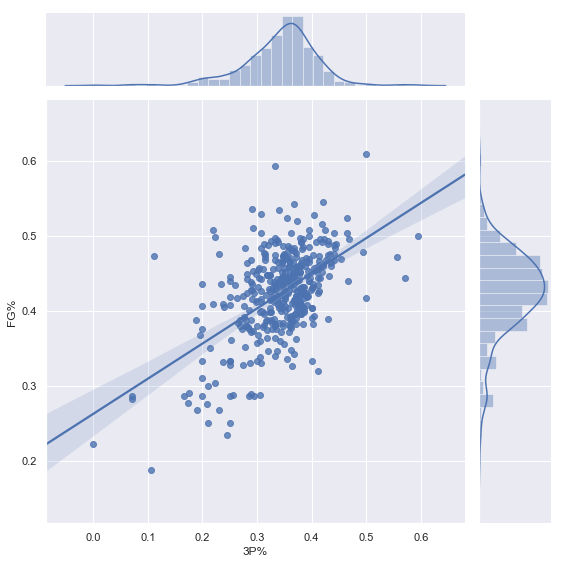

In [35]:
nba_df = nba_df.ix[nba_df['3PA']>1] 

sns.set(font_scale=1, style = 'darkgrid', context='notebook')
scoring_jointplot = sns.jointplot(x='3P%', 
                                  y='FG%', 
                                  height=8, 
                                  kind='reg', 
                                  data=nba_df)
plt.show()

After filtration, it definitely looks like some players do not have accuracy much higher than 60% in both overall and long range shots. There are also a couple of players who are incredibly inaccurate with both shots too - and because we constrained this to at least one 3 point attempt across an average of the entire years' games, we can be moderately confident that these are acceptable.

Now let's tackle this topic from a slightly different angle, and look instead at volume. Are there players who shoot a high volume of 3 Point shots that are also accurate and efficient overall? We can guess who might pop up here, but first for posterity, we will present jointplots with a contour graph (kernel density estimate) and a hexbin plot. 

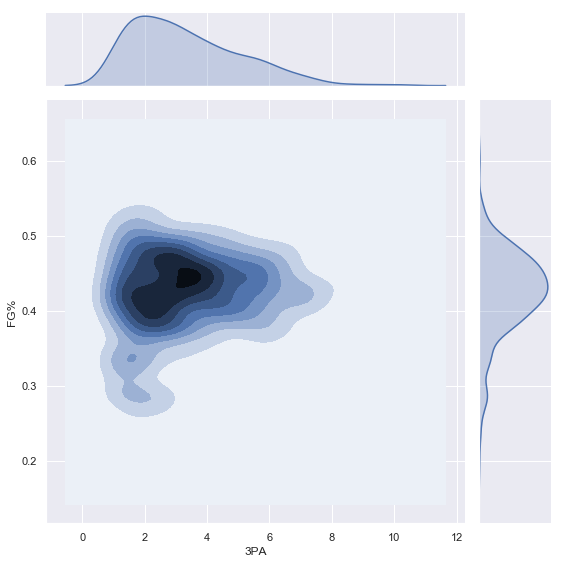

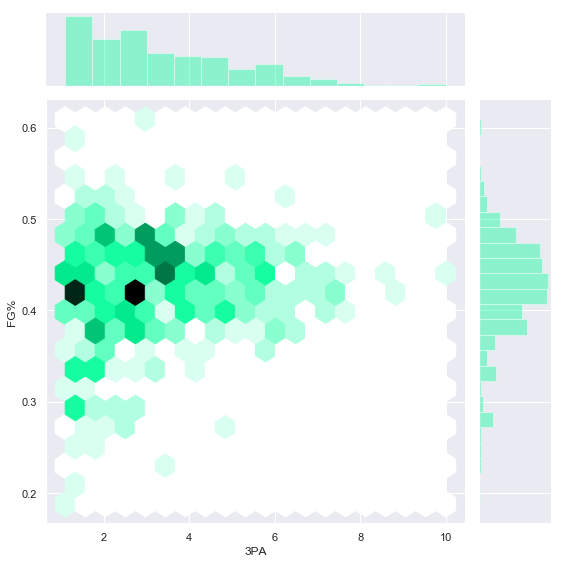

In [36]:
scoring_jointplot = sns.jointplot(x='3PA', 
                                  y='FG%', 
                                  height=8, 
                                  kind='kde', 
                                  data=nba_df)
plt.show()

scoring_jointplot = sns.jointplot(x='3PA', 
                                  y='FG%', 
                                  height=8, 
                                  kind='hex', 
                                  color='#00ff99',
                                  data=nba_df)
plt.show()

These plots are great for observing density in a two dimensional manner if your data is particularly dense (ours is not quite there). Based on this, we can also see that there is a slightly positive relationship between our variables. Let's run a regression again to see what this might look like.

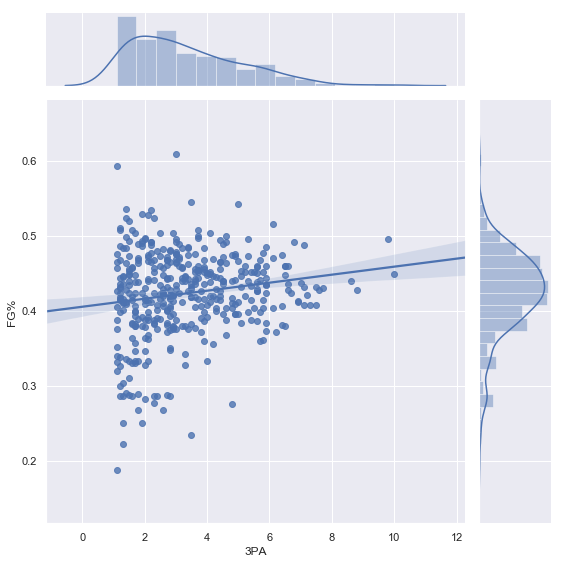

In [37]:
scoring_jointplot = sns.jointplot(x='3PA', y='FG%', height=8, kind='reg', data=nba_df)
plt.show()

We can see that at there are 4 players that take more than 8 long ranged shots a game and still maintain an overall accuracy comfortably above 40%. Let's take a look at who they are, once again using .ix to find them.

In [38]:
god_shooters = nba_df.ix[nba_df['3PA']>8] 
print(god_shooters)

      Rk                    Player  Pos  Age   Tm   G  GS    MP   FG   FGA  \
146  120   Stephen Curry\curryst01    2   29  GSW  51  51  32.0  8.4  16.9   
216  180     Eric Gordon\gordoer01    6   29  HOU  69  30  31.2  6.0  14.1   
232  194    James Harden\hardeja01    6   28  HOU  72  72  35.4  9.0  20.1   
369  298  Damian Lillard\lillada01    2   27  POR  73  73  36.6  8.5  19.4   

       ...     ORB  DRB  TRB  AST  STL  BLK  TOV   PF  PS/G  Position  
146    ...     0.7  4.4  5.1  6.1  1.6  0.2  3.0  2.2  26.4        PG  
216    ...     0.4  2.1  2.5  2.2  0.6  0.4  1.9  1.7  18.0        SG  
232    ...     0.6  4.8  5.4  8.8  1.8  0.7  4.4  2.3  30.4        SG  
369    ...     0.8  3.6  4.5  6.6  1.1  0.4  2.8  1.6  26.9        PG  

[4 rows x 31 columns]


At this point, we've almost answered our question. We can assume that the two points on the plot at the farthest right end are Steph Curry and James Harden. 

But we may want to visualise this in our data, so in order to do this we will use an superpositioned plot with just points at the coordinates for Curry and Harden. 

To strike it home, let's also annotate our plot at these points with some text. 

Finally, we can notice in the graph above that although we do not have any players taking less than 1 shot a game, the plot is still beginning at 0. This occurs in many of the graphs we generated and is subjectively quite unaesthetic. We can censor our figure's distribution to reflect this better.

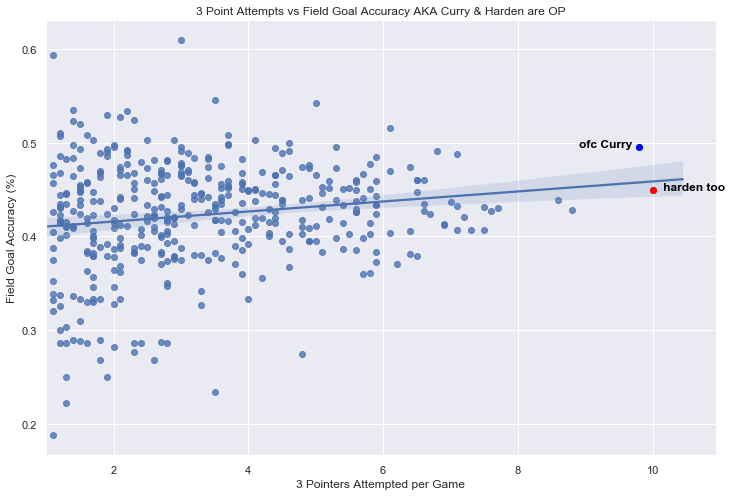

In [39]:
# Set coordinates for hightlighting
curry_x = nba_df.loc[146, '3PA']
curry_y = nba_df.loc[146, 'FG%']
harden_x = nba_df.loc[232, '3PA']
harden_y = nba_df.loc[232, 'FG%']

# Draw main scatterplot
scoring_scatterplot = sns.regplot(x='3PA', 
                                  y='FG%', 
                                  data=nba_df)

# Draw superimposed plots 
scoring_overlay = plt.scatter(curry_x, 
                              curry_y, 
                              color = 'blue')
scoring_overlay = plt.scatter(harden_x, 
                              harden_y, 
                              color = 'red')

# Label plot
scoring_scatterplot.text(curry_x, 
                         curry_y, 
                         'ofc Curry  ', 
                         horizontalalignment='right', 
                         size='medium', 
                         color='black', 
                         weight='semibold')
scoring_scatterplot.text(harden_x, 
                         harden_y, 
                         '   harden too', 
                         horizontalalignment='left', 
                         size='medium', 
                         color='black', 
                         weight='semibold')
plt.title('3 Point Attempts vs Field Goal Accuracy AKA Curry & Harden are OP')
plt.xlabel('3 Pointers Attempted per Game')
plt.ylabel('Field Goal Accuracy (%)')

# Apply censor
scoring_scatterplot.set(xlim=(1, None))
plt.show()

TODO: 
* Ridgeplot

## EXERCISE 1 - Data Exploration

We will now move onto the primary dataset for the remainder of the workshop. The goal here is to use the tools just presented to figure out what the data actually is, and how we can work with it. To ease in, we'll take a quick look at the dataframe. 

In [40]:
df_gm.head()

,rank,dead,online,name,level,class,id,experience,account,challenges,twitch,ladder
0,1,False,False,Tzn_NecroIsFineNow,100,Necromancer,3dcddd59f5088893f734f39686350990dae168cc4f4b00...,4250334444,TheTzn,40,thetzn,Harbinger
1,1,False,False,RaizNeverFirstQT,100,Necromancer,8f3216db5ac9106c287a834731aafc83c387138f28fc45...,4250334444,RaizQT,22,raizqt,SSF Harbinger HC
2,1,False,False,GucciStreamerAdvantage,100,Necromancer,c6ec2dae3855c551e0597c06ef2da06fbb5512487ded7f...,4250334444,GucciPradas,35,guccipradas,Hardcore Harbinger
3,1,False,False,ChiroxPrime,100,Slayer,c861372da792be0b22c45bf437ccd58437c52e9455e0bf...,4250334444,Chiroxun,26,null,SSF Harbinger
4,2,False,False,Cool_NecroIsFineNow,100,Deadeye,24ae924ceed7989ef3d3d6772612832bb467a6094352c7...,4250334444,cooltail,22,null,Harbinger


In [41]:
df_gm.dtypes

rank           int64
dead            bool
online          bool
name          object
level          int64
class         object
id            object
experience     int64
account       object
challenges     int64
twitch        object
ladder        object
dtype: object

So the data is from a game - Path of Exile to be precise. The data was acquired from [gagazet's kaggle](https://www.kaggle.com/gagazet/path-of-exile-league-statistic). You could just look at the kaggle page to derive meaning of the data - but try and consider what these data might mean through some exploration.

As the workshop is quite short, we will also set some broad and loose objectives for you to try and complete: 
* Try and identify the dataset and what the columns may mean before taking a look at the kaggle page.
* Try to isolate some points of interest, perhaps some columns/variables, and visualise them. 
* Come up with an interesting research question, and if time permits, visualise the results of your analyses. 

## DATA VISUALIZATION FOR HYPOTHESIS TESTING

<img src="presentations/figures/linear_reg.png" alt="drawing" width="400"/>

For better illustrating the functionalities of some visualization functions we will make use of fake data generated ad-hoc for serving our purposes. Here the focus will be to employ visuals for preliminary testing (or strengthening) our hypothesis.

### Visualize time series data across conditions

We will now plot time series data, showing how to compare across conditions and visualizing the units composing each time series.


It follows the structure of `df_ts`

In [42]:
df_ts.head(5)

,time,condition,individual,value
0,0,0,0,41.773512
1,1,0,0,83.085720
2,2,0,0,39.976984
3,3,0,0,-1.210432
4,4,0,0,41.621353


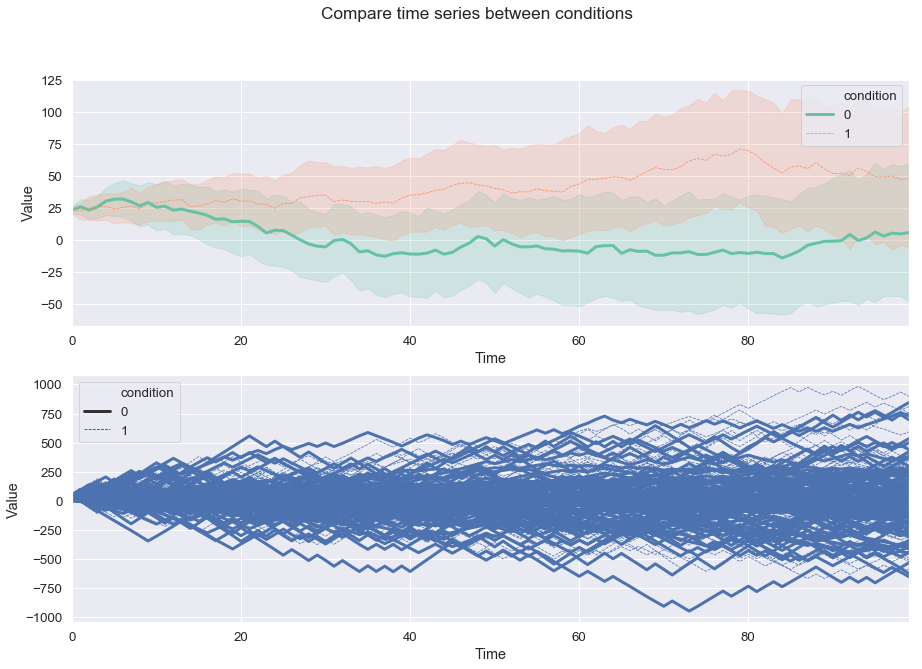

In [43]:
sns.set(font_scale=1.2)
# defining the axes structure 
fig,axs = plt.subplots(2, 1, figsize = (15, 10))
sns.lineplot(x='time'
             , y='value'
             , hue='condition'
             , size='condition'
             , style='condition'
             , data=df_ts
             , palette='Set2'
             , ax = axs[0]
            )
sns.lineplot(x='time'
             , y='value'
             , size='condition'
             , style='condition'
             , data=df_ts
             , palette='Set2'
             , units='individual'
             , estimator=None
             , ax = axs[1]
            )
# adjusting the axes aesthetic
plt.suptitle('Compare time series between conditions')
for ax in axs:
    
    ax.set_xlim(min(df_ts['time']), max(df_ts['time']))
    ax.set_xlim(min(df_ts['time']), max(df_ts['time']))
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.show()

The shaded area in the first plot shows the the standard deviation and the lines represents the mean. In the second plot each line corresponds to an unit while color and style (as in the first plot) code for the condtions.

Which of the two plots is a 'bad visualization'?

### Visualize the relationship between variables

We will now showcase various options for exploring the relationship between varibales. For our purposes we will generate a synthetic dataframe having 3 catgorical columns, 3 scalar columns and 1000 rows.


It follows the structure of `df_sy`

In [44]:
df_sy = generate_synthetic(n_categorical=3, n_scalar=3, n_rows=1000)
df_sy.head()

,categorical_0,categorical_1,categorical_2,scalar_0,scalar_1,scalar_2
0,xskNQ,UcTsp,QsLoD,1.515617,1.351697,-0.612283
1,jNsoD,UcTsp,QsLoD,-1.240085,0.055559,-1.570566
2,jNsoD,UcTsp,WAoKb,1.282810,0.175794,-0.579781
3,jNsoD,dZdVC,QsLoD,-0.103130,0.133139,1.010170
4,IRsPZ,dZdVC,WAoKb,-0.299291,-0.022211,-1.311941


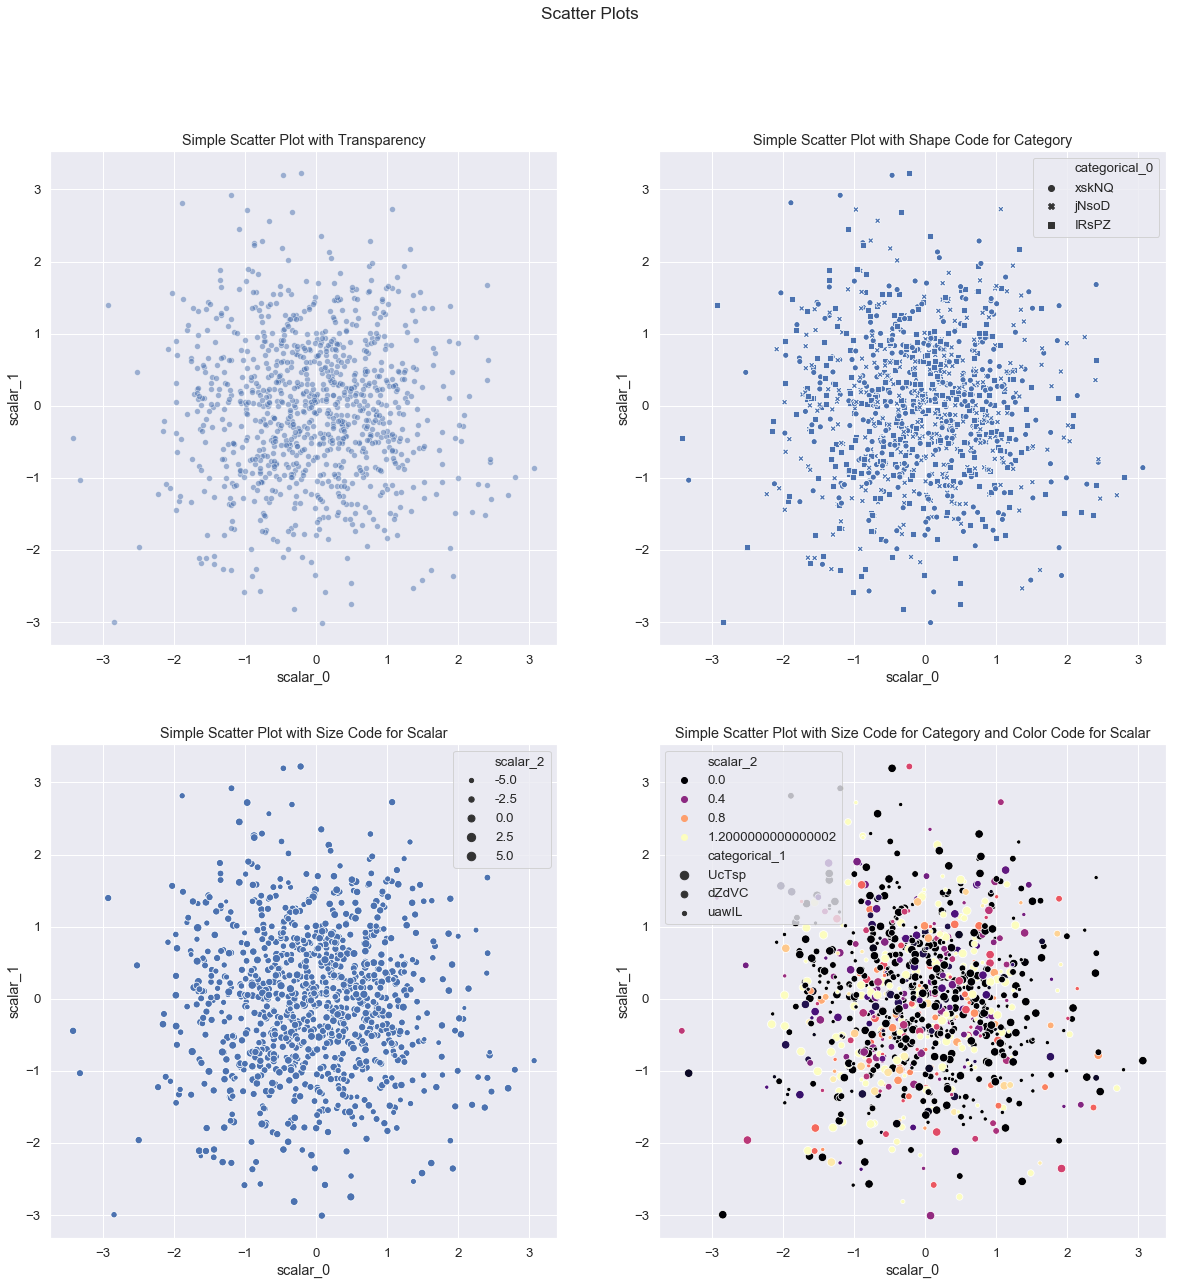

In [45]:
sns.set(font_scale=1.2)
# define the axes structure, being grid the axes will be stored in a 2d array
fig, axs = plt.subplots(2, 2, figsize=(20,20))
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , ax = axs[0][0]
                , alpha=0.5
               )
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , style='categorical_0'
                , ax = axs[0][1]
               )
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , size='scalar_2'
                , ax = axs[1][0]
               )
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , size='categorical_1'
                , hue='scalar_2'
                , hue_norm=(0,1)
                , palette='magma'
                , ax = axs[1][1]
               )
# adjusting the axes aesthetic
axs[0][0].set_title('Simple Scatter Plot with Transparency')
axs[0][1].set_title('Simple Scatter Plot with Shape Code for Category')
axs[1][0].set_title('Simple Scatter Plot with Size Code for Scalar')
axs[1][1].set_title('Simple Scatter Plot with Size Code for Category and Color Code for Scalar')
plt.suptitle('Scatter Plots')
plt.show()

Which reletionship between the variables can we observe?


In the first plot we adjust the alpha of the dots for overcoming the overplotting. In the second plot one categorical varibales is coded throught the shape of the dots. In the third plot we have a scalar varible represented throught the dimesnion of the dots. In the fourth plot a scalar variable is represented trhough a normalized color scale and a categorical varibale through the dimesnion of the dots.

Which plot is a 'bad visualization'?

It follows the structure of `df_ln` and `df_pl`

In [46]:
df_ln.head(5)

,condition,x,y
0,0,-3.000000,-11.985820
1,0,-2.793103,-11.159212
2,0,-2.586207,-10.332604
3,0,-2.379310,-9.505996
4,0,-2.172414,-8.679387


In [47]:
df_pl.head(5)

,condition,x,y
0,0,-3.000000,-30.474620
1,0,-2.793103,-21.749345
2,0,-2.586207,-14.539756
3,0,-2.379310,-8.703248
4,0,-2.172414,-4.097213


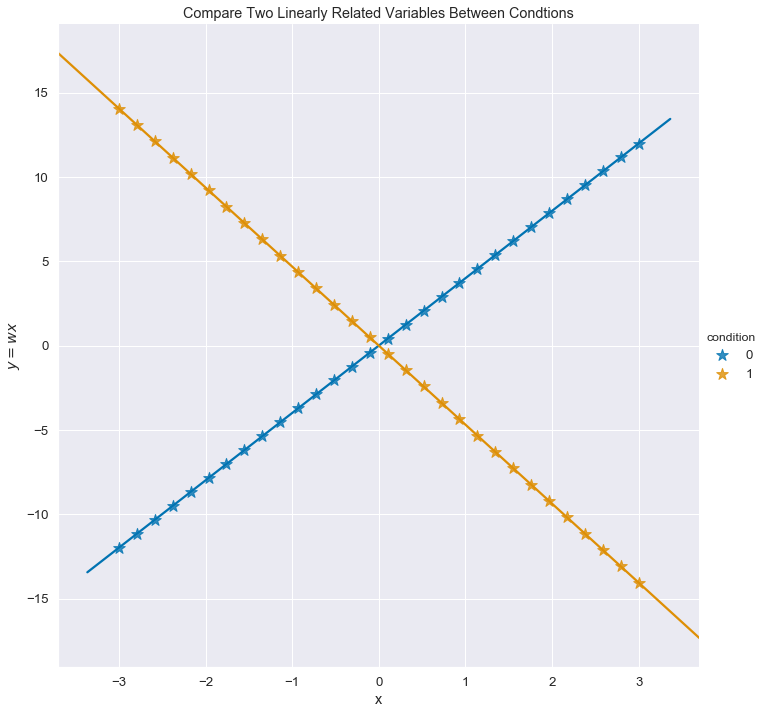

In [48]:
sns.set(font_scale=1.2, style = 'darkgrid')
sns.lmplot(x='x'
           , y='y'
           , hue='condition'
           , palette='colorblind'
           , markers='*'
           , data=df_ln
           , height=10
           , scatter_kws={'s': 150}
           )
plt.title('Compare Two Linearly Related Variables Between Condtions')
plt.xlabel('x')
plt.ylabel(r'$y=wx$')
plt.show()

`lmplot` will by default try to fit a line that best describe our data. Here, colour codes for condition while the shape of the markers is arbitrarly chosen. Using the Tex syntax we can write mathematical notation on our axes or titels.

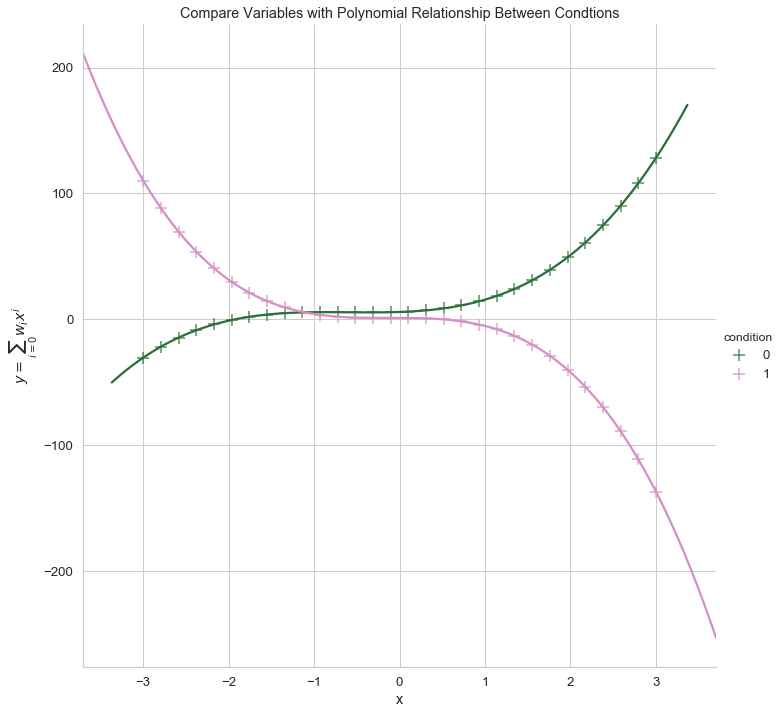

In [49]:
sns.set(font_scale=1.2, style ='whitegrid')
sns.lmplot(x='x'
           , y='y'
           , hue='condition'
           , palette='cubehelix'
           , markers='+'
           , order=3
           , data=df_pl
           , height=10
           , scatter_kws={'s': 150}
           )
plt.title('Compare Variables with Polynomial Relationship Between Condtions')
plt.xlabel('x')
plt.ylabel(r'$y=\sum_{i=0}w_ix^i$')
plt.show()

If the relationsp between our variables is not linear `lmplot` allows various options for drawing the best fit line. Being in this case a polynomial of order 3, we just need to specify the order in the plot function.

In [50]:
df_sy = generate_synthetic(n_categorical=0, n_scalar=10, n_rows=10000)
# create a corallation matrix and a bolead mask for hiding negative correlations
df_corr = df_sy.corr()
mask = df_corr < 0

It follows the structure of the correlation matrix and relative bolean mask.

In [51]:
df_corr.head(5)

,scalar_0,scalar_1,scalar_2,scalar_3,scalar_4,scalar_5,scalar_6,scalar_7,scalar_8,scalar_9
scalar_0,1.000000,0.005895,-0.007949,0.005897,-0.003370,0.008680,-0.005654,-0.006180,0.012002,0.004428
scalar_1,0.005895,1.000000,-0.003544,0.002517,0.009233,-0.008761,0.005916,0.007516,0.000530,-0.004156
scalar_2,-0.007949,-0.003544,1.000000,0.002948,0.008167,0.006245,0.007625,-0.003318,-0.005875,-0.001484
scalar_3,0.005897,0.002517,0.002948,1.000000,-0.006833,-0.007934,-0.002365,-0.013310,0.000074,0.006789
scalar_4,-0.003370,0.009233,0.008167,-0.006833,1.000000,-0.000320,-0.022512,0.003449,-0.007114,-0.000166


In [52]:
mask.head()

,scalar_0,scalar_1,scalar_2,scalar_3,scalar_4,scalar_5,scalar_6,scalar_7,scalar_8,scalar_9
scalar_0,False,False,True,False,True,False,True,True,False,False
scalar_1,False,False,True,False,False,True,False,False,False,True
scalar_2,True,True,False,False,False,False,False,True,True,True
scalar_3,False,False,False,False,True,True,True,True,False,False
scalar_4,True,False,False,True,False,True,True,False,True,True


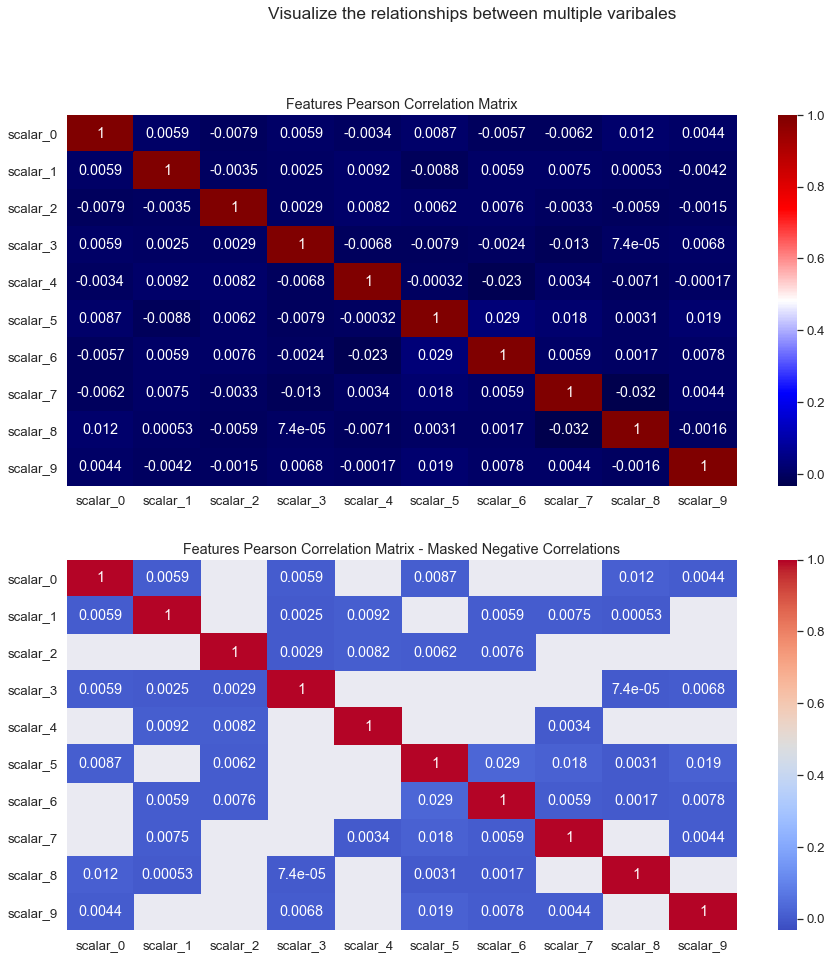

In [53]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(2,1,figsize=(15,15))
sns.heatmap(data=df_corr
            , cmap='seismic'
            , annot=True
            , ax = axs[0]
            )
sns.heatmap(data=df_corr
            , cmap='coolwarm'
            , annot=True
            , mask=mask
            , ax = axs[1]
            )
axs[0].set_title('Features Pearson Correlation Matrix')
axs[1].set_title('Features Pearson Correlation Matrix - Masked Negative Correlations')
plt.suptitle('Visualize the relationships between multiple varibales')
plt.show()

Heatmap allows to visualize the numerical annotation relative to each cell as well as applying a mask for hiding cells based on their value.

Is the color coding employed here approprihated?

### Compare  a variable between multiple conditions

In [54]:
df_sy = generate_synthetic(n_categorical=2, n_scalar=1, n_rows=1000)

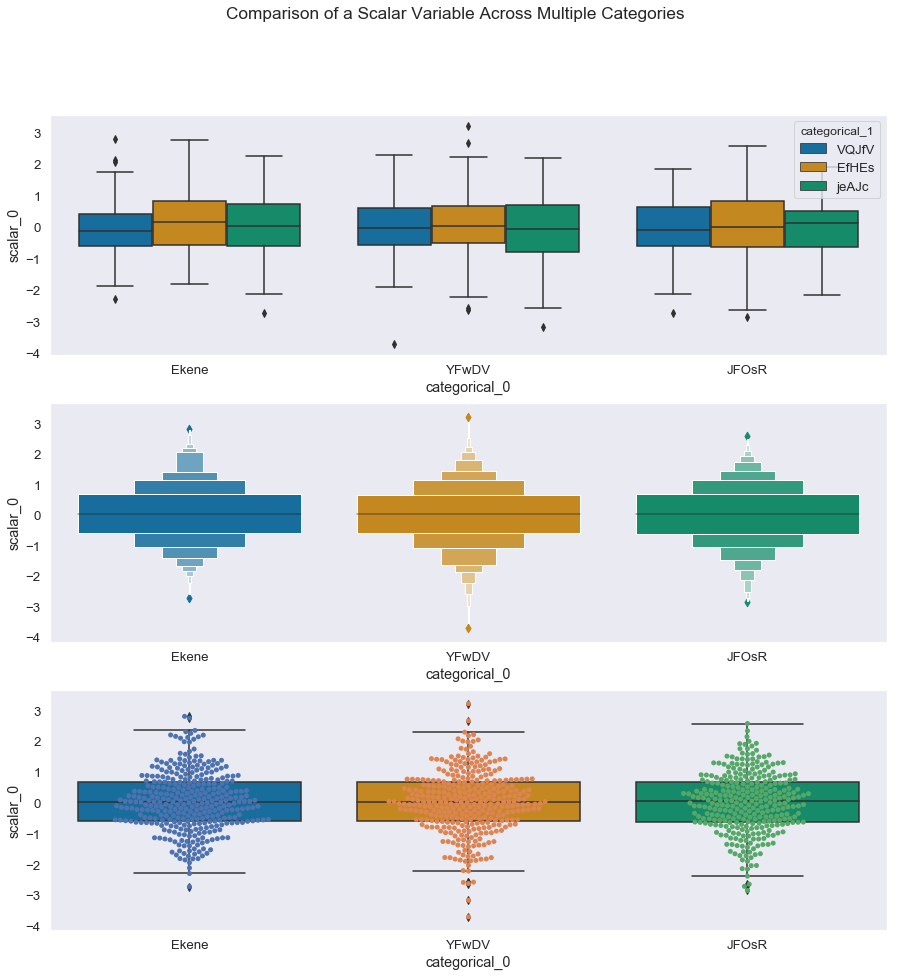

In [55]:
sns.set(font_scale=1.2, style='dark')
fig, axs = plt.subplots(3,1,figsize=(15,15))
sns.boxplot(x='categorical_0'
            , y='scalar_0' 
            , palette='colorblind'
            , hue='categorical_1'
            , ax=axs[0]
            , data=df_sy
            )
sns.boxenplot(x='categorical_0'
              , y='scalar_0' 
              , palette='colorblind'
              , ax=axs[1]
              , data=df_sy
              )
sns.boxplot(x='categorical_0'
            , y='scalar_0' 
            , palette='colorblind'
            , ax=axs[2]
            , data=df_sy
            )
sns.swarmplot(x='categorical_0'
              , y='scalar_0' 
              , cmap='colorblind'
              , ax=axs[2]
              , data=df_sy
              )

plt.suptitle('Comparison of a Scalar Variable Across Multiple Categories')
plt.show()

### EXERCISE 2

Using the `df_gm` formulate your own hypothesis and test it visually

* Given the data you have access to, think to a question you want, and you can, answer to
* Think at which kind of information you need to extract from the data for answering your question
* Think which visualization would best suit your purposes
* Think at which audience you want to present your visualization
* Think if you have any kind of constrains (i.e. temporal, skill ecc..) and how you can minimize their impact

It follows some informations regarding the `df_gm`

In [56]:
df_gm.head(2)

,rank,dead,online,name,level,class,id,experience,account,challenges,twitch,ladder
0,1,False,False,Tzn_NecroIsFineNow,100,Necromancer,3dcddd59f5088893f734f39686350990dae168cc4f4b00...,4250334444,TheTzn,40,thetzn,Harbinger
1,1,False,False,RaizNeverFirstQT,100,Necromancer,8f3216db5ac9106c287a834731aafc83c387138f28fc45...,4250334444,RaizQT,22,raizqt,SSF Harbinger HC


In [57]:
df_gm.dtypes

rank           int64
dead            bool
online          bool
name          object
level          int64
class         object
id            object
experience     int64
account       object
challenges     int64
twitch        object
ladder        object
dtype: object

In [58]:
df_gm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59776 entries, 0 to 59775
Data columns (total 12 columns):
rank          59776 non-null int64
dead          59776 non-null bool
online        59776 non-null bool
name          59776 non-null object
level         59776 non-null int64
class         59776 non-null object
id            59776 non-null object
experience    59776 non-null int64
account       59776 non-null object
challenges    59776 non-null int64
twitch        59776 non-null object
ladder        59776 non-null object
dtypes: bool(2), int64(4), object(6)
memory usage: 4.7+ MB


## DATA VISUALIZATION FOR MODEL EVALUATION

Here the focus won't be on the machine learning part but rather on how we can employ the visualizations we have seen so far for evaluating the performnce of the model. Differently for the previous sections, we will illustrate how in most of the case seaborn can work with simple itearables withouth the need of Pandas dataframes.

<img src="presentations/figures/send_nodes.png" alt="drawing" width="600"/>

In [59]:
classifiers = {'K-nearest Neighbors' : KNN(n_jobs = -1)
               , 'Logistic Regression' : LR(max_iter = 200, class_weight = 'balanced', solver='sag', n_jobs = -1)
               , 'Random Forest' : RF(class_weight = 'balanced', n_jobs = -1)
               , 'Multilayer Perceptron' :  MLPC(max_iter = 200)
              }
X, y = make_classification(n_samples = 5000, n_features=15, n_informative=5, n_redundant=5)
X_validation, y_validation, X_test, y_test = generating_validation_test(X, y)

### Visualize model performance

In the first part we will show how to compare the performance of different algorithms through boxplots while in the second part we will illustrate the use of heatmaps for detailing the performance of our best model.

In [60]:
splitter = StratifiedShuffleSplit(n_splits=5)

In [61]:
scores = []
names = []
for name, classifier in classifiers.items():
    
    for train_index, test_index in splitter.split(X, y):
        
        classifier.fit(X[train_index], y[train_index])
        scores.append(classifier.score(X[test_index], y[test_index]))
        names.append(name)

It follows the structure of `scores` and `names`

In [62]:
scores

[0.938,
 0.928,
 0.96,
 0.95,
 0.938,
 0.814,
 0.784,
 0.834,
 0.812,
 0.846,
 0.94,
 0.942,
 0.94,
 0.928,
 0.938,
 0.966,
 0.97,
 0.954,
 0.96,
 0.972]

In [63]:
names

['K-nearest Neighbors',
 'K-nearest Neighbors',
 'K-nearest Neighbors',
 'K-nearest Neighbors',
 'K-nearest Neighbors',
 'Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Random Forest',
 'Random Forest',
 'Random Forest',
 'Random Forest',
 'Random Forest',
 'Multilayer Perceptron',
 'Multilayer Perceptron',
 'Multilayer Perceptron',
 'Multilayer Perceptron',
 'Multilayer Perceptron']

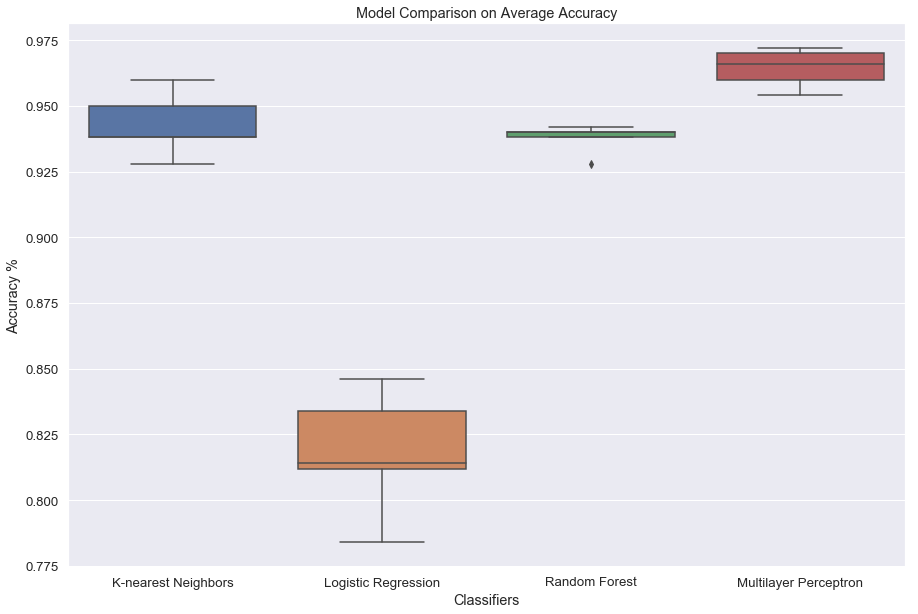

In [64]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(x = names
            , y = scores
            , orient = 'v'
            , ax = ax)
plt.title('Model Comparison on Average Accuracy')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy %')
plt.show()

In [65]:
splitter = StratifiedShuffleSplit(n_splits=3)
param_grid = {'hidden_layer_sizes' : [(10, 10, 10), (50, 50, 50), (100, 100, 100)]
              , 'activation' : ['tanh', 'relu']
              , 'alpha' : [1.0, 0.1, 0.001, 0.0001]
             }


In [66]:
searcher = GridSearchCV(estimator=classifiers['Multilayer Perceptron']
                        , param_grid=param_grid
                        , cv=splitter
                        , scoring = 'roc_auc'
                        , n_jobs = 2
                       )
searcher.fit(X_validation, y_validation)
best_estimator = searcher.best_estimator_
y_predicted = best_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)

It follows the structure of `cm`

In [67]:
cm

array([[737,  14],
       [ 41, 708]], dtype=int64)

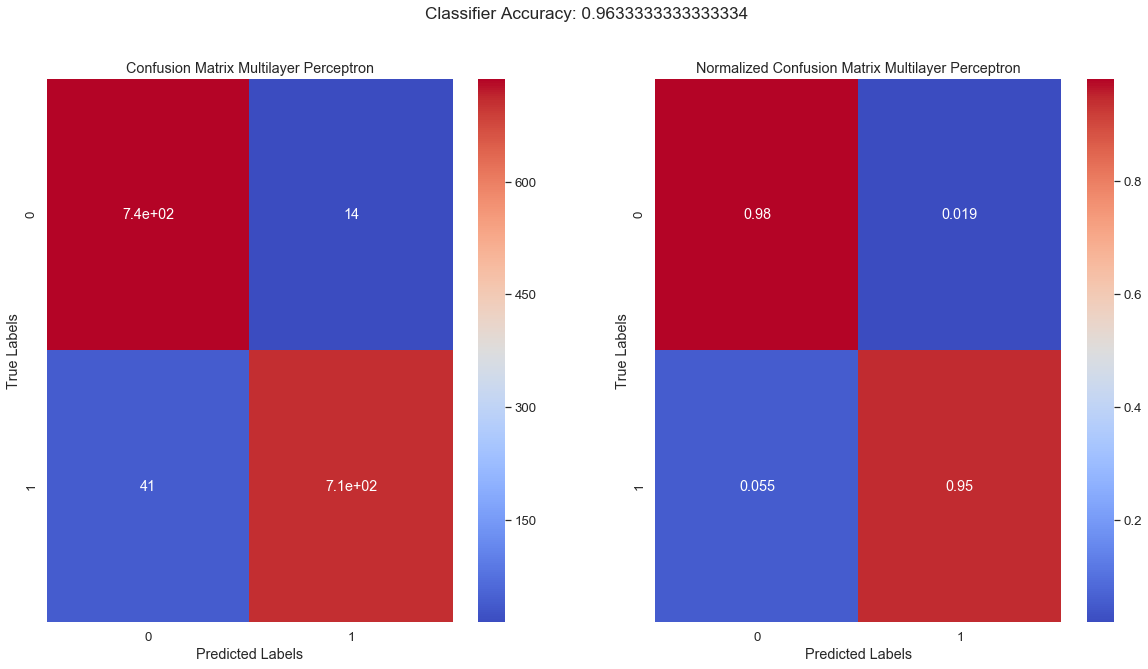

In [68]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
sns.heatmap(cm
            , annot = True
            , cmap='coolwarm'
            , ax=axs[0]
           )
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis]
            , annot = True
            , cmap='coolwarm'
            , ax=axs[1]
           )
for ax in axs:
    
    ax.set_xticks([0.5, 1.5], ['Positive', 'Negative'])
    ax.set_yticks([0.5, 1.5], ['Negative', 'Positive'])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

axs[0].set_title('Confusion Matrix Multilayer Perceptron')
axs[1].set_title('Normalized Confusion Matrix Multilayer Perceptron')
plt.suptitle('Classifier Accuracy: {}'.format(best_estimator.score(X_test, y_test)))
plt.show()

### Visualize the learning process 

In [69]:
best_estimator

MLPClassifier(activation='relu', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [70]:
loss_v = []
# accuracy
accuracy_v = []
accuracy_ts = []
# f1
f1_v = []
f1_ts = []
# precision
precision_v = []
precision_ts = []
# recall
recall_v = []
recall_ts = []

In [71]:
epochs = [i for i in range(150)]
model = MLPC(activation='relu', alpha=0.001, hidden_layer_sizes=(100, 100, 100), max_iter=1, warm_start=True)

for epoch in epochs:
    
    model.fit(X_validation, y_validation)
    v_predicted = model.predict(X_validation)
    ts_predicted = model.predict(X_test)
    loss_v.append(model.loss_)
    # accuracy
    accuracy_v.append(model.score(X_validation, y_validation))
    accuracy_ts.append(model.score(X_test, y_test))
    # f1
    f1_v.append(f1_score(v_predicted, y_validation))
    f1_ts.append(f1_score(ts_predicted, y_test))
    #precision
    precision_v.append(precision_score(v_predicted, y_validation))
    precision_ts.append(precision_score(ts_predicted, y_test))
    #recall
    recall_v.append(recall_score(v_predicted, y_validation))
    recall_ts.append(recall_score(ts_predicted, y_test))

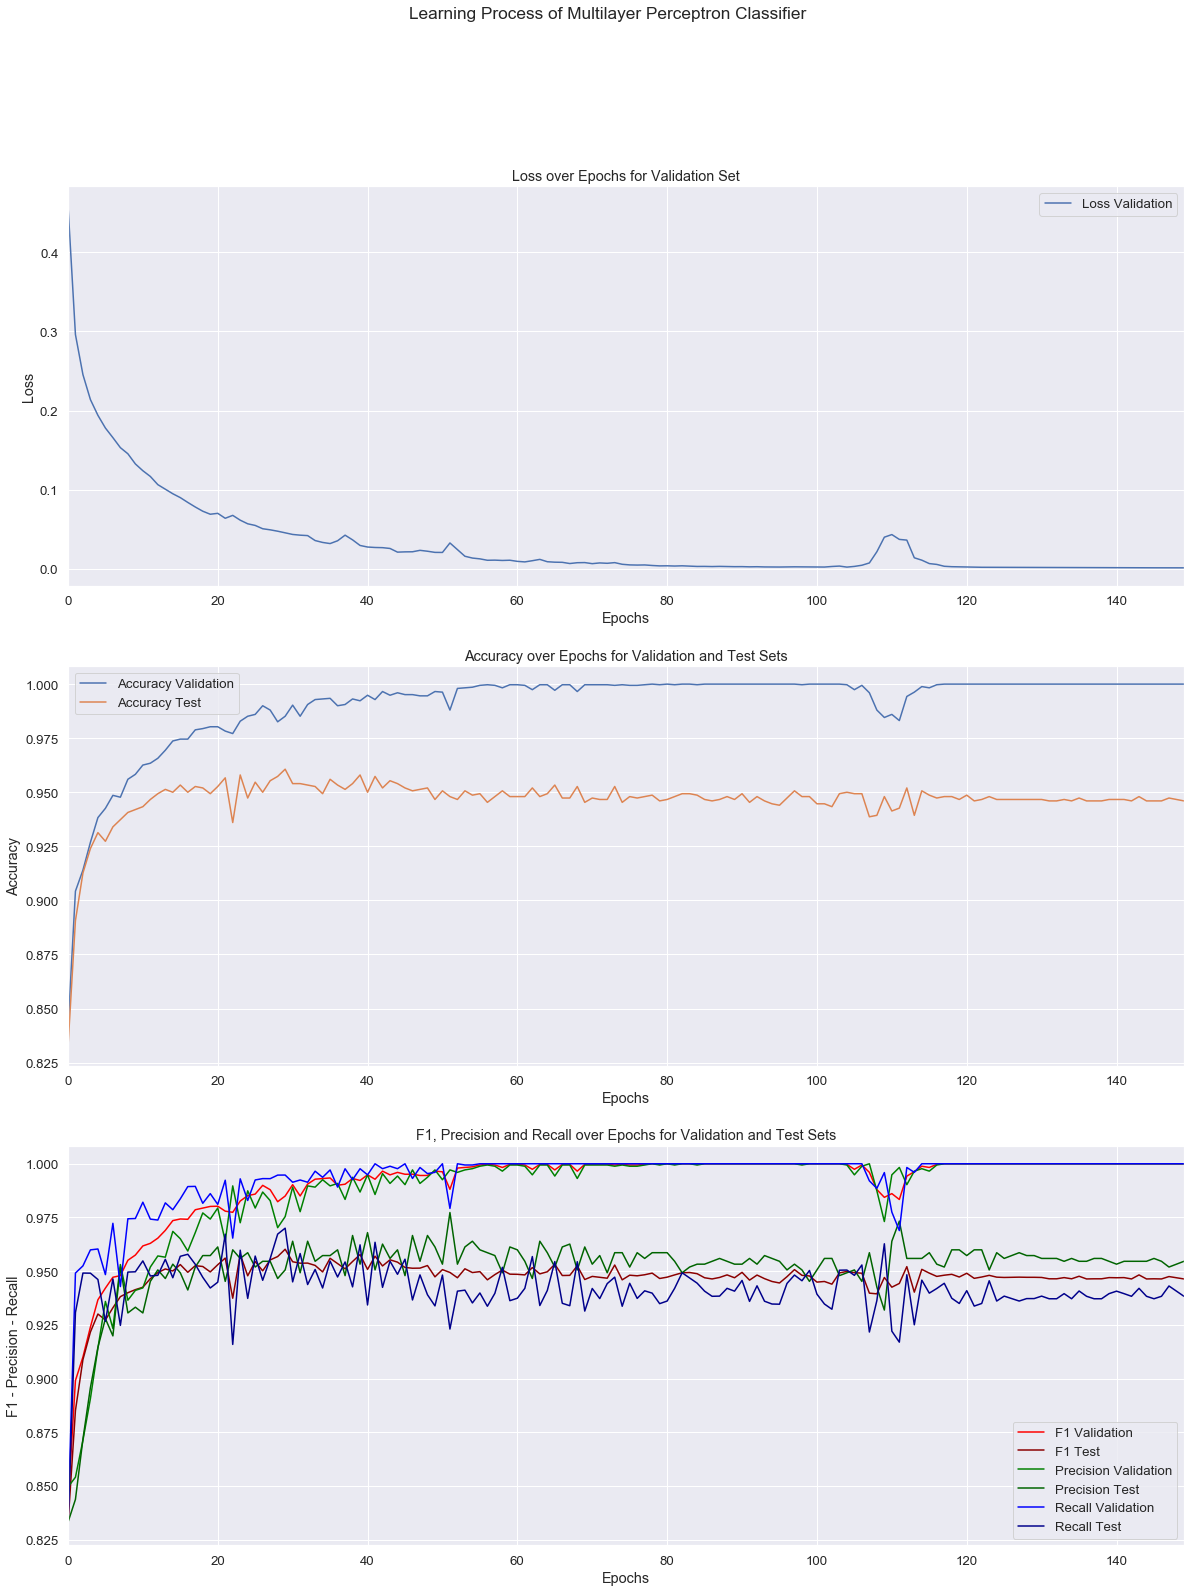

In [72]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(3, 1, figsize = (20, 25))
# loss
sns.lineplot(y=loss_v
             , x=epochs
             , label='Loss Validation'
             , ax=axs[0]
            )
# accuracy
sns.lineplot(y=accuracy_v
             , x=epochs
             , label='Accuracy Validation'
             , ax=axs[1]
            )
sns.lineplot(y=accuracy_ts
             , x=epochs
             , label = 'Accuracy Test' 
             , ax=axs[1]
            )
# f1, precision, recall
sns.lineplot(y=f1_v
             , x=epochs
             , label='F1 Validation'
             , color='red'
             , ax=axs[2]
            )
sns.lineplot(y=f1_ts
             , x=epochs
             , label = 'F1 Test'
             , color='darkred'
             , ax=axs[2]
            )
sns.lineplot(y=precision_v
             , x=epochs
             , label='Precision Validation'
             , color='green'
             , ax=axs[2]
            )
sns.lineplot(y=precision_ts
             , x=epochs
             , label='Precision Test'
             , color='darkgreen'
             , ax=axs[2]
            )
sns.lineplot(y=recall_v
             , x=epochs
             , label='Recall Validation'
             , color='blue'
             , ax=axs[2]
            )
sns.lineplot(y=recall_ts
             , x=epochs
             , label='Recall Test'
             , color='darkblue'
             , ax=axs[2]
            )

for ax in axs:
    
    ax.set_xlabel('Epochs')

    ax.set_xlim(min(epochs), max(epochs))

axs[0].set_title('Loss over Epochs for Validation Set')
axs[0].set_ylabel('Loss')
axs[1].set_title('Accuracy over Epochs for Validation and Test Sets')
axs[1].set_ylabel('Accuracy')
axs[2].set_title('F1, Precision and Recall over Epochs for Validation and Test Sets')
axs[2].set_ylabel('F1 - Precision - Recall')
plt.suptitle('Learning Process of Multilayer Perceptron Classifier')
plt.legend()
plt.show()

In [73]:
n_clusters = [i for i in range(2, 8)]
inertias = []
for n in n_clusters:
    
    clusterer = KMeans(n_clusters = n).fit(X)
    inertias.append(clusterer.inertia_)

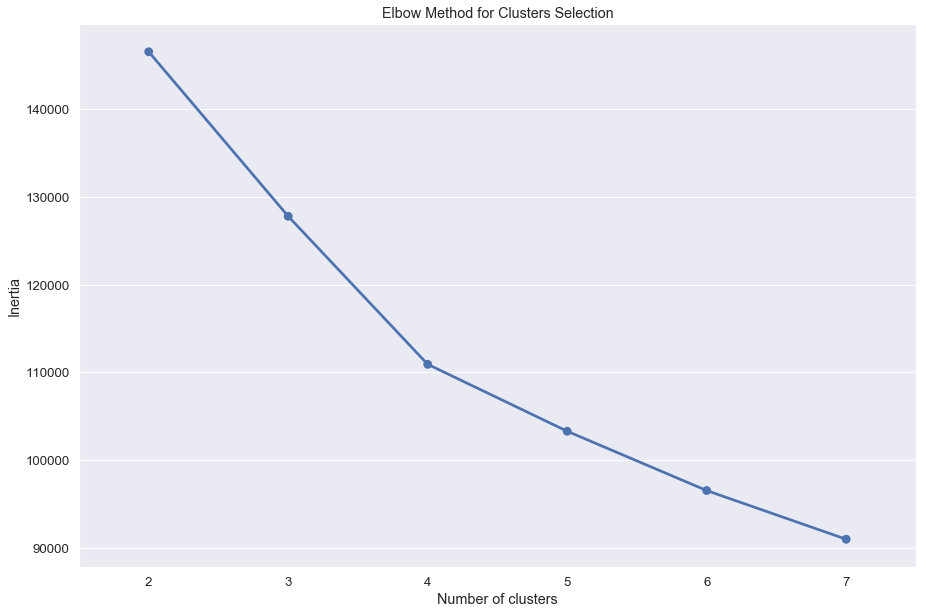

In [74]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(15, 10))
sns.pointplot(y=inertias
             , x=n_clusters
             , ax=ax
            )

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
plt.title('Elbow Method for Clusters Selection')
plt.show()

### Visually inspect the prediction

In [75]:
y_predicted = classifiers['Logistic Regression'].fit(X_validation, y_validation).predict(X_test)
major_components = PCA(n_components = 2).fit_transform(X_test)

colors_gt = ['b' if label == 0 else 'y' for label in y_test]

colors_er = ['r' if prediction != ground_truth else 'w' for prediction, ground_truth in zip(y_predicted, y_test)]
colors_er_0 = ['r' if prediction != ground_truth and prediction == 0 else 'w' for prediction, ground_truth in zip(y_predicted, y_test)]
colors_er_1 = ['r' if prediction != ground_truth and prediction == 1 else 'w' for prediction, ground_truth in zip(y_predicted, y_test)]

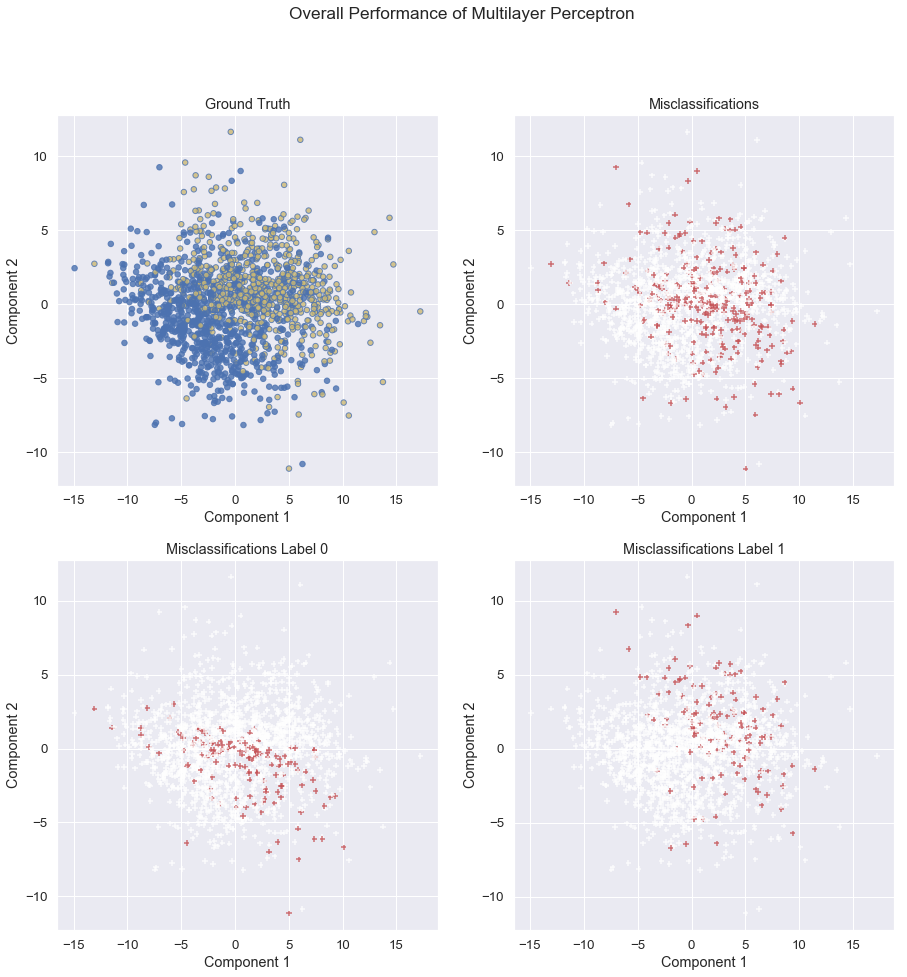

In [76]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_gt, 's':30}
            , ax=axs[0][0]
           )
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_er, 's':30}
            , ax=axs[0][1]
            , marker='+'
           )
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_er_0, 's':30}
            , ax=axs[1][0]
            , marker='+'
           )
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_er_1, 's':30}
            , ax=axs[1][1]
            , marker='+'
           )
for ax in axs.flatten():
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

axs[0][0].set_title('Ground Truth')
axs[0][1].set_title('Misclassifications')
axs[1][0].set_title('Misclassifications Label 0')
axs[1][1].set_title('Misclassifications Label 1')

plt.suptitle('Overall Performance of Multilayer Perceptron')
plt.show()

In [77]:
locations_er_0 = []
locations_er_1 = []
for location, prediction, ground_truth in zip(major_components, y_predicted, y_test):
    
    if prediction != ground_truth and prediction == 0:
        locations_er_0.append(location)
    elif prediction != ground_truth and prediction == 1:
        locations_er_1.append(location)

locations_er_0 = np.array(locations_er_0)
locations_er_1 = np.array(locations_er_1)

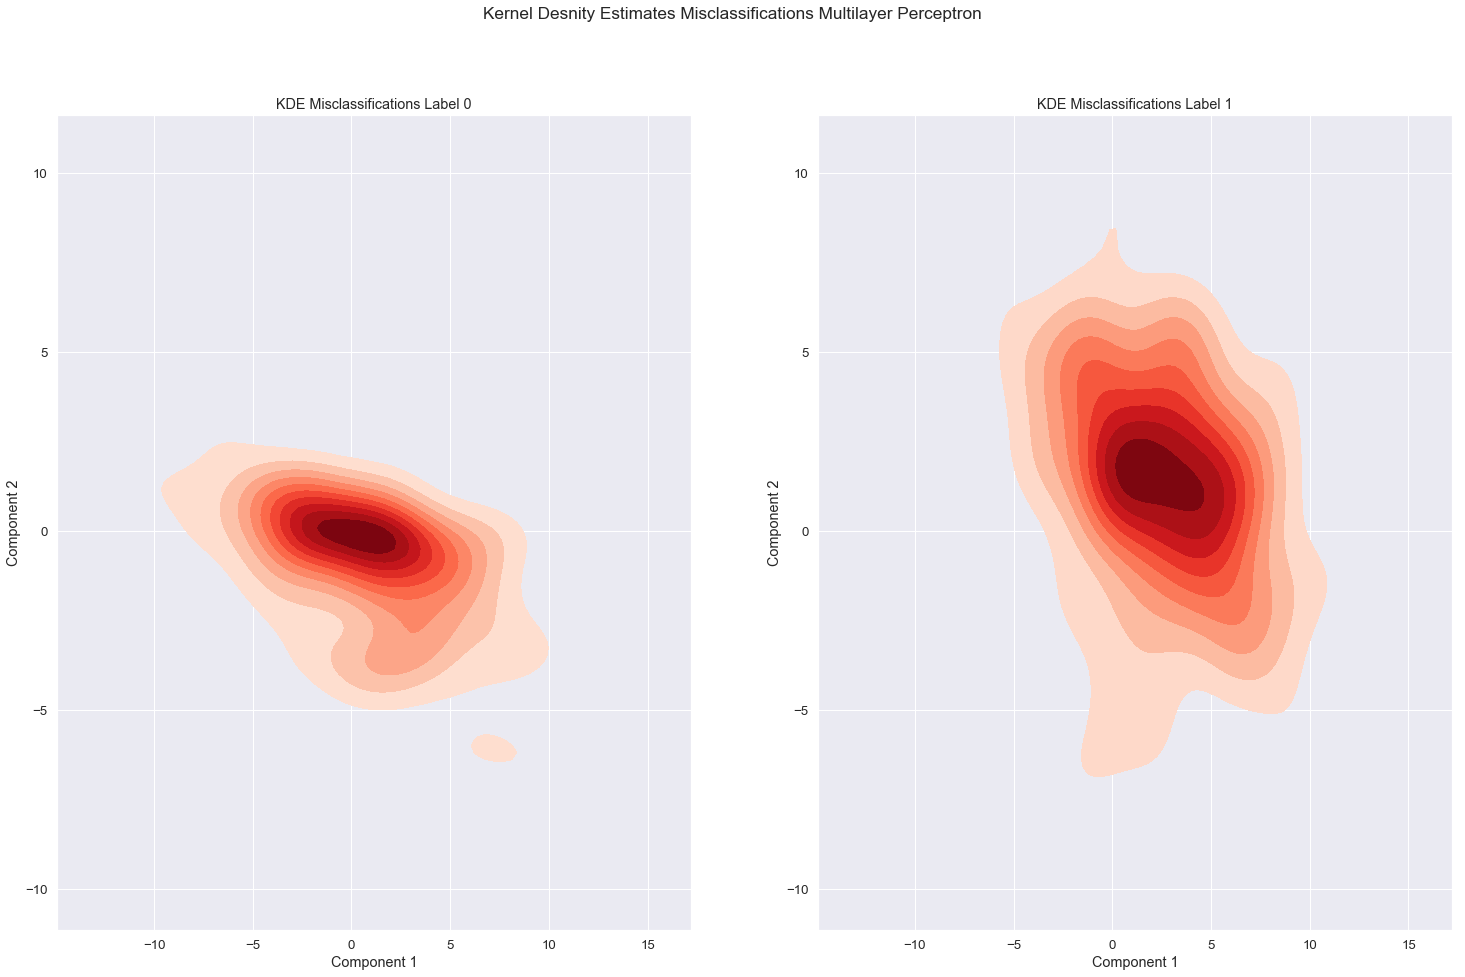

In [78]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(1, 2, figsize=(25, 15))
sns.kdeplot(locations_er_0[:,0]
        , locations_er_0[:,1]
        , cmap='Reds'
        , shade=True
        , shade_lowest=False
        , ax=axs[0]
        )
sns.kdeplot(locations_er_1[:,0]
        , locations_er_1[:,1]
        , cmap='Reds'
        , shade=True
        , shade_lowest=False
        , ax=axs[1]
        )

for ax in axs.flatten():
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_xlim(min(major_components[:,0]), max(major_components[:,0]))
    ax.set_ylim(min(major_components[:,1]), max(major_components[:,1]))

axs[0].set_title('KDE Misclassifications Label 0')
axs[1].set_title('KDE Misclassifications Label 1')
plt.suptitle('Kernel Desnity Estimates Misclassifications Multilayer Perceptron')
plt.show()

In [79]:
components_corr = np.append(X_test, major_components, axis = 1)
components_corr = pd.DataFrame(components_corr).corr()
components_corr = components_corr[[15, 16]]

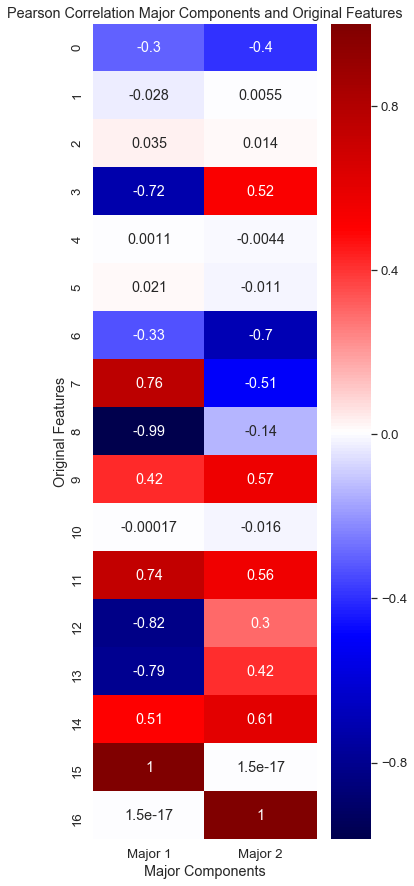

In [80]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5, 15))
sns.heatmap(components_corr
            , annot = True
            , cmap='seismic'
            , ax = ax
           )
plt.title('Pearson Correlation Major Components and Original Features')
ax.set_xticklabels(labels=['Major 1', 'Major 2'])
ax.set_xlabel('Major Components')
ax.set_ylabel('Original Features')
plt.show()

### EXERCISE 2

In the following cells you will find arrays containing preprocessed data. You can use one of the out-of-the-box models that `scikit-learn` offers in the attempt to predict if a player died or not.

In case you prefer doing your own preprocessing (suggested) you can use the `df_ml`, which has been already prepared for being in a machine learning friendly format.

The goal here is to pick a strategy for solving the classification problem and using a visual for validating the outcomes of your strategy.

It follows some information on `df_ml`

In [81]:
df_ml.head(2)

,rank,dead,online,name,level,experience,account,challenges,twitch,class_Ascendant,...,class_Scion,class_Shadow,class_Slayer,class_Templar,class_Trickster,class_Witch,ladder_Harbinger,ladder_Hardcore Harbinger,ladder_SSF Harbinger,ladder_SSF Harbinger HC
0,1,0,0,18,100,4250334444,6,40,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,16,100,4250334444,6,22,1,0,...,0,0,0,0,0,0,0,0,0,1


In [82]:
df_ml.dtypes

rank                         int64
dead                         int64
online                       int64
name                         int64
level                        int64
experience                   int64
account                      int64
challenges                   int64
twitch                       int64
class_Ascendant              int64
class_Assassin               int64
class_Berserker              int64
class_Champion               int64
class_Chieftain              int64
class_Deadeye                int64
class_Duelist                int64
class_Elementalist           int64
class_Gladiator              int64
class_Guardian               int64
class_Hierophant             int64
class_Inquisitor             int64
class_Juggernaut             int64
class_Marauder               int64
class_Necromancer            int64
class_Occultist              int64
class_Pathfinder             int64
class_Raider                 int64
class_Ranger                 int64
class_Saboteur      

In [83]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59776 entries, 0 to 59775
Data columns (total 39 columns):
rank                         59776 non-null int64
dead                         59776 non-null int64
online                       59776 non-null int64
name                         59776 non-null int64
level                        59776 non-null int64
experience                   59776 non-null int64
account                      59776 non-null int64
challenges                   59776 non-null int64
twitch                       59776 non-null int64
class_Ascendant              59776 non-null int64
class_Assassin               59776 non-null int64
class_Berserker              59776 non-null int64
class_Champion               59776 non-null int64
class_Chieftain              59776 non-null int64
class_Deadeye                59776 non-null int64
class_Duelist                59776 non-null int64
class_Elementalist           59776 non-null int64
class_Gladiator              59776 non-nu

In [84]:
X, y = generate_X_y(df_ml, list(df_ml.drop('dead', 1)), 'dead')
X_validation, y_validation, X_test, y_test = generating_validation_test(X, y)